In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import re
import sys
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
import tensorflow as tf
sys.path.insert(1, "../")
import grapher

dataset = pd.read_csv("../datasets/financial_sent.zip", compression="zip", encoding="latin-1")
dataset.head()


,Label,Data
0,neutral,"According to Gran , the company has no plans t..."
1,neutral,Technopolis plans to develop in stages an area...
2,negative,The international electronic industry company ...
3,positive,With the new production plant the company woul...
4,positive,According to the company 's updated strategy f...


Plot the count of sentiment spread

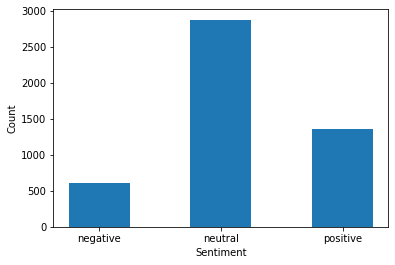

In [2]:
grapher.bar_chart(dataset["Label"].values, 0.5, "Sentiment", "Count")

Convert the string versioned sentiment to integer. Having three categories requires later use of SparseCategoricalCrossentropy.

In [3]:
sentiment = {"positive": 0, "neutral": 1, "negative": 2}

dataset.Label = [sentiment[item] for item in dataset.Label]
dataset.head()

,Label,Data
0,1,"According to Gran , the company has no plans t..."
1,1,Technopolis plans to develop in stages an area...
2,2,The international electronic industry company ...
3,0,With the new production plant the company woul...
4,0,According to the company 's updated strategy f...


Clean up the data

In [4]:
useless_words = ["to", "the", "for", "by", "has", "had", "were", "a", "an", "and", "what", "will", "can", "into", "in", "out", "are", "but", "if", "about", "why", "how", "where", "when", "too", "there", "now"]
punctuation = "!,&.()?:"
def remove_junk(text, removable_data):
    if type(removable_data) == str:
        text = "".join([char for char in text if char not in punctuation])
    else:
        text = " ".join([word for word in text.split() if word not in removable_data])
    return text
dataset["Data"] = dataset["Data"].apply(lambda sentence: remove_junk(sentence, punctuation))
dataset["Data"] = dataset["Data"].apply(lambda sentence: remove_junk(sentence, useless_words))
dataset.head()

,Label,Data
0,1,According Gran company no plans move all produ...
1,1,Technopolis plans develop stages area of no le...
2,2,The international electronic industry company ...
3,0,With new production plant company would increa...
4,0,According company 's updated strategy years 20...


Create a tokenizer, compute max length for padding, and build the train and test datasets

In [5]:
tokenizer = Tokenizer(oov_token="<OOV>")
tokenizer.fit_on_texts(dataset.Data)
max_sentence_length = dataset.Data.map(len).max() # map the length of each setence and return max
sequences = tokenizer.texts_to_sequences(dataset["Data"].tolist())
padded_sequences = pad_sequences(sequences, padding="post", maxlen=max_sentence_length)
x_train, x_test, y_train, y_test = train_test_split(padded_sequences, dataset.Label, test_size=0.3)

Build the model and compile to check for accuracy.

In [6]:
embedding_dim = 16
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(len(tokenizer.word_index) + 1, embedding_dim, input_length=max_sentence_length),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(6, activation='relu'),
    tf.keras.layers.Dense(3, activation='sigmoid')
])
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),optimizer='adam',metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 281, 16)           173408    
_________________________________________________________________
global_average_pooling1d (Gl (None, 16)                0         
_________________________________________________________________
dense (Dense)                (None, 6)                 102       
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 21        
Total params: 173,531
Trainable params: 173,531
Non-trainable params: 0
_________________________________________________________________


Time to train

In [7]:
epochs = 30
history = model.fit(x_train, y_train, epochs=epochs, validation_data=(x_test, y_test))

Epoch 1/30
106/106 [==============================] - 2s 12ms/step - loss: 1.0664 - accuracy: 0.5978 - val_loss: 0.9698 - val_accuracy: 0.5942
Epoch 2/30
106/106 [==============================] - 0s 2ms/step - loss: 0.9539 - accuracy: 0.5894 - val_loss: 0.9233 - val_accuracy: 0.5942
Epoch 3/30
106/106 [==============================] - 0s 2ms/step - loss: 0.9316 - accuracy: 0.5867 - val_loss: 0.9180 - val_accuracy: 0.5942
Epoch 4/30
106/106 [==============================] - 0s 2ms/step - loss: 0.9086 - accuracy: 0.5923 - val_loss: 0.9148 - val_accuracy: 0.5942
Epoch 5/30
106/106 [==============================] - 0s 2ms/step - loss: 0.9217 - accuracy: 0.5908 - val_loss: 0.9100 - val_accuracy: 0.5942
Epoch 6/30
106/106 [==============================] - 0s 2ms/step - loss: 0.9006 - accuracy: 0.5991 - val_loss: 0.9047 - val_accuracy: 0.5942
Epoch 7/30
106/106 [==============================] - 0s 2ms/step - loss: 0.9181 - accuracy: 0.5808 - val_loss: 0.8975 - val_accuracy: 0.5942
Epoch

Graph the accuracy and loss

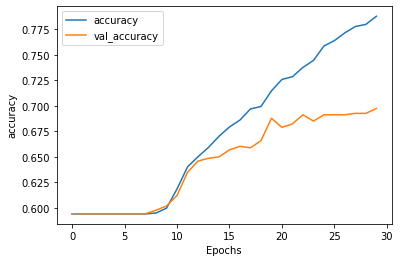

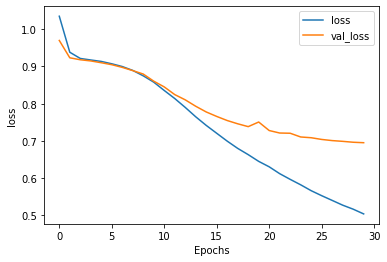

In [8]:
grapher.plot_history_graph(history, "accuracy")
grapher.plot_history_graph(history, "loss")